[View in Colaboratory](https://colab.research.google.com/github/BobZhangHT/KDD-Air-Project/blob/master/RNN_Models.ipynb)

In [4]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive  -o nonempty

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

%matplotlib inline

Using TensorFlow backend.


In [0]:
# Generate yielding timeseries samples and their targets (similar with codes from Deep Learning with Python)

def generator(data,lookback,delay,min_index,max_index,
                     shuffle=False,batch_size=128,step=6):
    # data: original array, first col indicates response variable
    # lookback: how many timesteps back the input data shold be
    # delay: how many timesteps in the future the target should be
    # min_index, max_index: indicate the beginning and end of timesteps to draw from
    # shuffle: whether to shuffle the data or sample in chronological order
    # batch_size: size of samples per batch
    # step: the period, in timesteps, at which we sample data (mainly for shrinking data size)
    
    if max_index is None:
        max_index=len(data)-delay-1
    i=min_index+lookback
    while 1:
        if shuffle:
            rows=np.random.randint(min_index+lookback,max_index,size=batch_size)
        else:
            if i+batch_size>=max_index:
                i=min_index+lookback
            rows=np.arange(i,min(i+batch_size,max_index))
            i+=len(rows)
            
        samples=np.zeros((len(rows),lookback//step,data.shape[-1]))
        targets=np.zeros((len(rows),delay))
        
        for j,row in enumerate(rows):
            indices_spl=np.arange(rows[j]-lookback,rows[j],step,dtype=np.int64)
            samples[j]=data[indices_spl]
            indices_tgt=np.arange(rows[j],rows[j]+delay,dtype=np.int64)
            targets[j]=data[indices_tgt][1]
        yield samples, targets

In [5]:
# load the data
dat=pd.read_table('./drive/dat4nn.txt',header=None,delim_whitespace=True)
dat=np.array(dat)
dat

array([[ 0.49237545, -1.31158826,  1.50796416, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.63266203, -1.2111115 ,  1.48764176, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.71568878, -1.19101615,  1.45715816, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.48676759,  0.73813757, -0.28548783, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47130744,  0.59747011, -0.24992363, ...,  0.        ,
         1.        ,  0.        ],
       [-0.45928288,  0.05489563, -0.20927882, ...,  0.        ,
         1.        ,  0.        ]])

In [0]:
# some global parameters
lookback=240
step=3
delay=24
batch_size=128
train_ind=1e4
val_ind=10800
test_ind=None

In [0]:
# train, val, test data genration
train_gen=generator(dat,lookback=lookback,delay=delay,
                    min_index=0,max_index=train_ind,shuffle=False,step=step,batch_size=batch_size)
val_gen=generator(dat,lookback=lookback,delay=delay,
                    min_index=train_ind+1,max_index=val_ind,shuffle=False,step=step,batch_size=batch_size)
test_gen=generator(dat,lookback=lookback,delay=delay,
                    min_index=val_ind+1,max_index=test_ind,shuffle=False,step=step,batch_size=batch_size)

val_step=val_ind-train_ind-1-lookback
test_step=len(dat)-val_ind-1-lookback

# GRU based Baseline

In [0]:
# model pipline
model=Sequential()
model.add(layers.GRU(32,input_shape=(None,dat.shape[-1])))
model.add(layers.Dense(24))

model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,steps_per_epoch=200,epochs=20,validation_data=val_gen,validation_steps=val_step)

Epoch 1/20
199/200 [============================>.] - ETA: 0s - loss: 0.7305

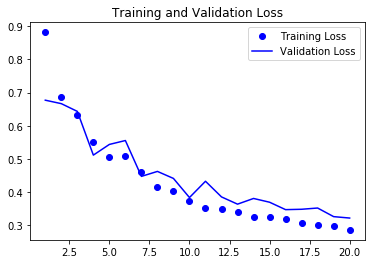

In [0]:
# plot

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(loss)+1)

plt.figure()

plt.plot(epochs,loss,'r--',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()